In [213]:
#Kaggle: Ames home sale
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.mpl_style', 'default')
pd.set_option('display.width', 3000)

na_values=['NA', 'N/A']
data_train = pd.read_csv('train.csv', na_values=na_values)
data_train = data_train.drop(data_train[(data_train.LotArea > 50000) & (data_train.SalePrice < 200000)].index)
data_test = pd.read_csv('test.csv', na_values=na_values)
data_all = pd.concat([data_train, data_test])
data_all = data_all.drop(['SalePrice'], axis=1)
#data_all.to_csv('data_all.csv')
m_train = data_train.shape[0]
m_test = data_test.shape[0]
#data_all.columns

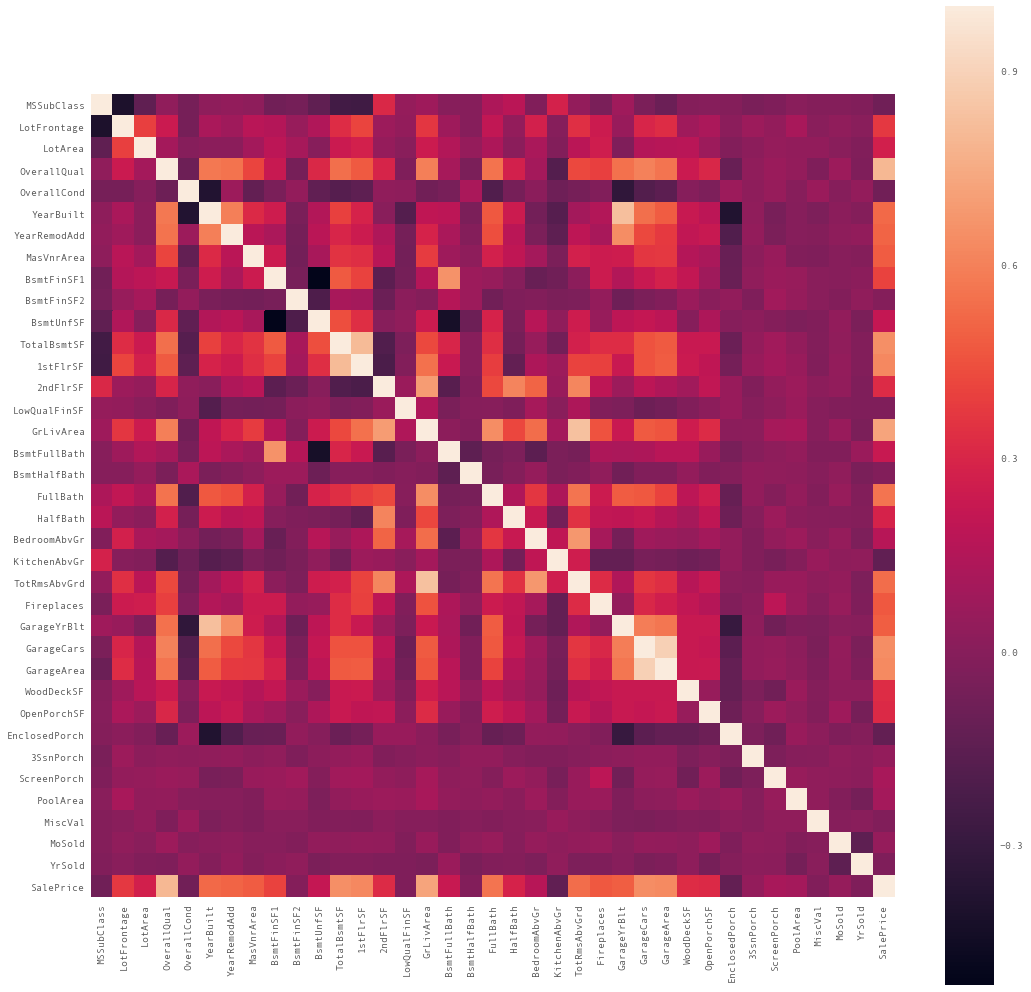

In [216]:
#data_all.describe()
#data_all['Street'].value_counts().sort_index().plot(kind='bar')

# plt.figure(figsize=(18,6))
#data_train['TotalBsmtSF'].value_counts().sort_index().plot(kind='bar')
#data_train[data_train['LotArea']<20000].sample(1000).plot.scatter(x='YearBuilt', y='SalePrice')
#data_train[data_train['LotArea']<15000].sample(200).plot.scatter(x='TotRmsAbvGrd', y='SalePrice')
#sns.kdeplot(data_train[data_train['SalePrice']<500000]['SalePrice'])
#sns.lmplot(x='LotArea', y='SalePrice', data=data_train[data_train['LotArea']<100000], fit_reg=False)
#sns.jointplot(x='TotalBsmtSF', y='SalePrice', data=data_train[data_train['LotArea']<20000].sample(len(data_train)/6))
#sns.heatmap(data_train.loc[:, ['LotFrontage', 'LotArea', 'SalePrice']].corr(), annot=True)
# data_train[data_train['LotArea']<1]['LotArea'].plot.hist(bins=30)
#data_train[data_train['TotalBsmtSF']<100000]['TotalBsmtSF'].plot.hist(bins=50)
plt.figure(figsize=(18,18))
sns.heatmap(data_train.iloc[:,1:].corr(), vmax=1, square=True)
#np.log(data_train['SalePrice']).plot.hist(bins=50)

In [ ]:
# plt.figure(figsize=(12,12))
# sns.set()
# n=10
# corrmat = data_train.iloc[:, 1:].corr()
# cols = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
# cc = np.corrcoef(data_train[cols].values.T)
# sns.heatmap(cc, cbar=True, annot=False, square=True, yticklabels=cols.values, xticklabels=cols.values)

# #pair plot
# cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'GarageArea', '1stFlrSF', 'FullBath', 
#         'TotRmsAbvGrd', 'YearBuilt']
# sns.pairplot(data_train[cols], size=2.5)

In [202]:
##Data pre-processing: imputer and dtype transform
##imputing missing values: numbered values fill(0), categorical values fill('None'), features with single-digits NA fill with mode()[0]
# #check missing data
# data_all_na = data_all.isnull().sum()
# data_all_na = data_all_na.drop(data_all_na[data_all_na==0].index).sort_values(ascending=False)
# missing_data = pd.DataFrame({'missing': data_all_na})

fill_none_features = ['PoolQC', 'Alley', 'Fence', 'MiscFeature', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                      'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                      'BsmtFinType2', 'MasVnrType',]
fill_zero_features = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
                      'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
fill_mode_features = ['Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

def Imputing_na(data, fill_none_features, fill_zero_features, fill_mode_features):
    for feature in fill_none_features:
        data[feature] = data[feature].fillna('None')
    for feature in fill_zero_features:
        data[feature] = data[feature].fillna(0)
    for feature in fill_mode_features:
        data[feature] = data[feature].fillna(data[feature].mode()[0])
    return data

data_all = Imputing_na(data_all, fill_none_features, fill_zero_features, fill_mode_features)

##dtype transform: numeric to categorical
dtype_features = ['MSSubClass', 'MoSold', 'OverallCond']
for feature in dtype_features:
    data_all[feature] = data_all[feature].apply(str)
    
##LotFrontage imputering
data_all['LotFrontage'] = data_all.groupby("Neighborhood")['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [203]:
#Feature engineering
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.special import boxcox1p

#Add features: 'TotalSF'
data_all['TotalSF'] = data_all['TotalBsmtSF'] + data_all['1stFlrSF'] + data_all['2ndFlrSF']
# data_all['BuiltAge'] = data_all['YrSold'] - data_all['YearBuilt']
# data_all['RemodelAge'] = data_all['YrSold'] - data_all['YearRemodAdd']
#Convert features
def BuiltAge(data):
    data['BuiltAge'] = data['YrSold'] - data['YearBuilt']
    bins = (-5,2,5,10,15,20,30,40,50,60,80,100,150)
    group_names=['2','5','10','15','20','30','40','50','60','80','100','150']
    categories = pd.cut(data['BuiltAge'], bins, labels=group_names)
    data['BuiltAge'] = categories
    return data

def RemodelAge(data):
    data['RemodelAge'] = data['YrSold'] - data['YearRemodAdd']
    bins = (-5, 1, 5, 10, 15, 20, 30, 40, 50, 60)
    group_names=['1', '5', '10', '15', '20', '30', '40', '50', '60']
    categories = pd.cut(data['RemodelAge'], bins, labels=group_names)
    data['RemodelAge'] = categories
    return data

#Feature transform
def Stand_Scaler(data):
    norm_features = ['PoolArea', 'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']
    Scaler = StandardScaler()
    Scaler = Scaler.fit(data[norm_features])
    dt = Scaler.transform(data[norm_features])
    dt = pd.DataFrame(dt)

    for i, feature in enumerate(norm_features):
        data.loc[:, feature] = dt.iloc[:, i]
    return data

def encode_features(data, features):
    for feature in features:
        le = preprocessing.LabelEncoder().fit(data[feature])
        data[feature] = le.transform(data[feature])
    return data

def feature_transform(data):
    e_features = ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BuiltAge', 'RemodelAge',
                  'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 
                  'Fence','FireplaceQu', 'Functional', 'GarageCars', 'GarageCond', 'GarageFinish', 'GarageQual', 
                  'Heating', 'HeatingQC', 'HouseStyle','KitchenQual', 'LandSlope', 'MasVnrType', 'MiscFeature', 
                  'MoSold', 'MSSubClass', 'OverallCond', 'PavedDrive', 'PoolQC', 'RoofMatl', 'Street']
    data = BuiltAge(data)
    data = RemodelAge(data)
    data = Stand_Scaler(data)
    data = encode_features(data, e_features)
    return data

data_all=feature_transform(data_all)
data_all = data_all.drop(['Utilities', 'GarageYrBlt', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'MiscFeature', 'PoolQC',
                          'Alley'], axis=1)

#column re-arrangement
cols = data_all.columns.tolist()
cols = cols[41:42] + cols[48:49] + cols[:41] + cols[42:48] + cols[49:]
data_all = data_all[cols]

#Categorical features without ordering
# categ_features = ['BldgType', 'CentralAir', 'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'LandContour',
#                   'LotConfig', 'LotShape', 'MSZoning', 'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType']

data_all = pd.get_dummies(data_all)

data_all.sample(2)

,Id,LotFrontage,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
744,2205,69.951807,932,442,0,3,4,3,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
556,2017,75.000000,844,893,0,3,4,3,397.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [204]:
from scipy.stats import skew
from scipy.special import boxcox1p

#Calculate skewness of numeric features
float_numeric = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'MasVnrArea', 'OpenPorchSF', 'EnclosedPorch', 
                 'BsmtFinSF1', 'BsmtFinSF2', '3SsnPorch', 'MiscVal','WoodDeckSF', 'ScreenPorch', 'LowQualFinSF', 
                 'TotalSF', 'LotArea', 'LotFrontage']
skewness = data_all[float_numeric].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'skewness': skewness})
skew_features = skewness[abs(skewness)>0.5].index
#BoxCox transform of highly skewed features

lam = 0.2
for feature in skew_features:
    data_all[feature] = boxcox1p(data_all[feature], lam)
#data_all[skew_features] = np.log1p(data_all[skew_features])
skewness_bc = data_all[skew_features].apply(lambda x: skew(x)).sort_values(ascending=False)
#skewness, skewness_bc

In [ ]:
# feature engineering: filling null data 'LotFrontage' by XGBoost

# import xgboost as xgb
# from xgboost import XGBRegressor

# data_LF_notnull = data_all.loc[data_all.LotFrontage.notnull()]
# data_LF_isnull = data_all.loc[data_all.LotFrontage.isnull()]

# x_lf_train = data_LF_notnull.iloc[:, 2:]
# y_lf_train = data_LF_notnull.iloc[:, 1]
# x_lf_test = data_LF_isnull.iloc[:, 2:]

# xgbr = xgb.XGBRegressor(n_estimator=100)
# xgbr.fit(x_lf_train, y_lf_train)
# y_lf_hat = xgbr.predict(x_lf_test)
# data_all.loc[(data_all.LotFrontage.isnull()), 'LotFrontage'] = y_lf_hat
              
# data_all_lf = data_all.LotFrontage
# data_all_lf = data_all_lf.reshape(-1,1)
# data_all_lf = boxcox1p(data_all_lf, 0.2)
# data_all['LotFrontage'] = data_all_lf

# data_all.to_csv('data_all_eng.csv')

In [205]:
from sklearn.model_selection import train_test_split

d_train = data_all.iloc[:m_train, :]
d_test = data_all.iloc[m_train:, :]

x = d_train.iloc[:, 1:]
y = np.log(data_train['SalePrice'])

test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 1)
mse_dict = {}

In [162]:
#Linear regression model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, RobustScaler

degree = 2
linear_models =[Pipeline([('Scale', RobustScaler()),
                            ('Poly', PolynomialFeatures(degree=degree)),
                              ('Linear', LassoCV(alphas = np.logspace(-3,2,5), cv=3, fit_intercept=False))]),
                Pipeline([('Scale', RobustScaler()),
                            ('Poly', PolynomialFeatures(degree=degree)),
                              ('Linear', RidgeCV(alphas = np.logspace(-3,2,5), cv=3, fit_intercept=False))]),
                Pipeline([('Scale', RobustScaler()),
                            ('Poly', PolynomialFeatures(degree=degree, include_bias=True)),
                          ('Linear', ElasticNetCV(l1_ratio=[0.1, 0.2, 0.3, 0.5, 0.9, 0.99, 1], alphas=np.logspace(-3,2,5), fit_intercept=False, max_iter=1e3, cv=3))])
               ]

mse_list = []
for i in range(3):
    model = linear_models[i]
    model.fit(x_train, y_train)
    linear = model.get_params('linear')['Linear']
    if hasattr(linear, 'alpha_'):
        print 'alpha for model %d: %.2f.' % (i+1, linear.alpha_)
    if hasattr(linear, 'l1_ratio_'):
        print 'l1_ratio for model %d: %.2f.' % (i+1, linear.l1_ratio_)
    y_hat = model.predict(x_test)
    mse = mean_squared_error(y_hat, y_test)
    mse_list.append(mse)
print (mse_list)

lin = linear_models[mse_list.index(min(mse_list))]
lin.fit(x_train, y_train)
y_hat_lin = lin.predict(x_test)
print lin
print mean_squared_error(y_hat_lin, y_test)
mse_dict['Linear'] = mean_squared_error(y_hat_lin, y_test)

#eli5.show_weights(lin, feature_names = list(x_train.columns))

# y_pred_lin = lin.predict(d_test.drop('Id', axis=1))
# Ames_lin = pd.DataFrame(data={'Id': d_test['Id'], 'SalePrice': np.exp(y_pred_lin)})
# Ames_lin.to_csv('Ames_lin.csv')

alpha for model 1: 0.02.
alpha for model 2: 0.32.
alpha for model 3: 0.02.
l1_ratio for model 3: 1.00.
[0.023443448671292357, 2.3444696887843346, 0.023443448671292357]
Pipeline(memory=None,
     steps=[('Scale', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('Poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('Linear', LassoCV(alphas=array([1.00000e-03, 1.77828e-02, 3.16228e-01, 5.62341e+00, 1.00000e+02])...alse,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])
0.023443448671292357


In [ ]:
#Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

krr = KernelRidge(alpha = 0.5, kernel='polynomial', degree=2, coef0=5)
krr.fit(x_train, y_train)
y_hat_krr = krr.predict(x_test)
print krr
print mean_squared_error(y_hat_krr, y_test)
mse_dict['KRR'] = mean_squared_error(y_hat_krr, y_test)

# y_pred_krr = krr.predict(d_test.drop('Id', axis=1))
# Ames_krr = pd.DataFrame(data={'Id': d_test['Id'], 'SalePrice': np.exp(y_pred_krr)})
# Ames_krr.to_csv('Ames_krr.csv')

In [ ]:
#Decison tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import eli5

dtr = DecisionTreeRegressor()
parameters = {'criterion': ['mse'], 'max_depth': [5, 8, 10,15,20], 'max_features': ['log2', 'sqrt', 'auto'], 'min_samples_leaf': [2,3,5,8]}
grid = GridSearchCV(dtr, parameters, scoring = make_scorer(mean_squared_error), n_jobs=-1, verbose=1)
grid.fit(x_train, y_train)
dtr = grid.best_estimator_
y_hat_dtr = dtr.predict(x_test)
print dtr
print mean_squared_error(y_hat_dtr, y_test)
mse_dict['DecisionTree'] = mean_squared_error(y_test, y_hat_dtr)

# y_pred_dtr = dtr.predict(d_test.drop('Id', axis=1))
# Ames_dtr = pd.DataFrame(data={'Id': d_test['Id'], 'SalePrice': np.exp(y_pred_dtr)})
# Ames_dtr.to_csv('Ames_dtr.csv')
eli5.show_weights(dtr, feature_names=list(x_train.columns))

In [147]:
#Ensemble: Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor(n_jobs=-1)

parameters = {'n_estimators':[20,100],
             'max_features':['log2','sqrt','auto'],
             'criterion':['mse'],
              'max_depth':[3,5,8],
             'min_samples_split':[2,3,5],
             'min_samples_leaf':[3,5,8]}
grid = GridSearchCV(rfr, parameters, scoring = make_scorer(mean_squared_error),n_jobs=-1,verbose=1)
grid = grid.fit(x_train, y_train)
rfr=grid.best_estimator_
rfr.fit(x_train, y_train)

#serializing model using either pickle or joblib
# filename = rfr_final.sav
# pickle.dump(rfr, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

y_hat_rfr = rfr.predict(x_test)
print rfr
print (mean_squared_error(y_test, y_hat_rfr))
mse_dict['RandomForest'] = mean_squared_error(y_test, y_hat_rfr)

# y_pred_rfr = rfr.predict(d_test.drop('Id', axis=1))
# Ames_rfr = pd.DataFrame(data={'Id': d_test['Id'], 'SalePrice': np.exp(y_pred_rfr)})
# Ames_rfr.to_csv('Ames_rfr.csv')
eli5.show_weights(rfr, feature_names=list(x_train.columns))

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  1.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.05545689526268674


Weight,Feature
0.0921 ± 0.4445,GarageCars
0.0712 ± 0.2956,KitchenQual
0.0690 ± 0.4151,TotalSF
0.0546 ± 0.3095,BRAge
0.0532 ± 0.3209,Foundation_PConc
0.0528 ± 0.2890,BsmtQual
0.0468 ± 0.2056,BsmtFinSF1
0.0450 ± 0.3230,FullBath
0.0343 ± 0.1876,2ndFlrSF
0.0337 ± 0.1902,GrLivArea


In [ ]:
#Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor()
params = {'loss': ['ls'], 'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [20, 100, 1000], 'max_depth': [3,5,8],
         'min_samples_split': [5,8,10], 'max_features': ['auto', 'log2', 'sqrt']}
gbr=GridSearchCV(gbr, params, cv=3, n_jobs=-1, verbose=1)
gbr.fit(x_train, y_train)
y_hat_gbr = gbr.predict(x_test)
print gbr
print mean_squared_error(y_hat_gbr, y_test)
mse_dict['GradientBoosting'] = mean_squared_error(y_hat_gbr, y_test)

# y_pred_gb = gbr.predict(d_test.drop('Id', axis=1))
# Ames_gb = pd.DataFrame(data={'Id': d_test['Id'], 'SalePrice': np.exp(y_pred_gb)})
# Ames_gb.to_csv('Ames_gb.csv')

In [206]:
#XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
import eli5

xgbr = xgb.XGBRegressor(base_score=0.1)

params = {'max_depth': [5], 'learning_rate': [0.05], 'n_estimators': [1000], 'objective': ['reg:linear'], 'gamma': [i/10.0 for i in range(1,2)], 'reg_alpha': [i/10.0 for i in range(0,2)], 'reg_lambda': [0.5, 1.0]}

xgbr = GridSearchCV(xgbr, params, cv=3, n_jobs=-1, verbose=1)
xgbr.fit(x_train, y_train)
y_hat_xgb = xgbr.predict(x_test)
#y_hat_train_xgb=xgbr.predict(x_train)

print xgbr
print mean_squared_error(y_hat_xgb, y_test)
print mean_squared_error(y_hat_train_xgb, y_train)
mse_dict['XGBoost'] = mean_squared_error(y_hat_xgb, y_test)

# y_pred_xgb = xgbr.predict(d_test.drop('Id', axis=1))
# Ames_xgb = pd.DataFrame(data={'Id': d_test['Id'], 'SalePrice': np.exp(y_pred_xgb)})
# Ames_xgb.to_csv('Ames_xgb.csv')


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   14.1s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.1, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg_alpha': [0.0, 0.1], 'learning_rate': [0.05], 'n_estimators': [1000], 'reg_lambda': [0.5, 1.0], 'objective': ['reg:linear'], 'max_depth': [5], 'gamma': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)
0.019842801577351556
0.007406145051080204


In [207]:
x_test_copy = x_test.copy()
x_test_copy['y_actual'] = y_test
x_test_copy['y_hat'] = y_hat_xgb
x_test_copy['residual'] = x_test_copy['y_actual'] - x_test_copy['y_hat']
x_test_copy = x_test_copy.sort_values(by = 'residual', axis=0)
x_test_copy.head(10)
#x_test_copy['RemodelAge'].plot.hist(bins=30)

,LotFrontage,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,y_actual,y_hat,residual
632,7.186239,16.327352,0.000000,0.0,3,4,3,14.144762,0.000000,0,...,0,0,0,0,0,0,1,11.320554,12.171892,-0.851339
30,5.977009,13.262182,13.367719,0.0,3,4,3,0.000000,0.000000,6,...,0,0,0,0,0,0,1,10.596635,11.354506,-0.757871
462,6.377215,14.336293,0.000000,0.0,3,4,3,12.687724,10.768883,5,...,0,0,0,0,0,0,1,11.041048,11.652242,-0.611194
916,5.977009,12.194875,0.000000,0.0,1,4,0,5.977009,0.000000,1,...,0,0,0,0,0,0,1,10.471950,11.067847,-0.595897
1453,7.324755,15.437470,0.000000,0.0,3,4,3,0.000000,0.000000,6,...,0,0,0,0,0,0,1,11.344507,11.816764,-0.472257
1062,7.186239,16.360479,14.559110,0.0,5,4,3,0.000000,0.000000,6,...,0,0,0,0,0,0,1,11.407565,11.839194,-0.431629
1337,8.692229,13.502989,0.000000,0.0,2,4,3,0.000000,0.000000,6,...,0,0,0,0,0,0,1,10.868568,11.276207,-0.407639
1349,5.977009,14.656361,15.699351,0.0,4,0,3,10.204239,0.000000,3,...,0,0,0,0,0,0,1,11.711776,12.097065,-0.385289
1186,7.754245,14.964719,13.460133,0.0,3,4,2,11.898872,0.000000,1,...,0,0,0,0,0,0,1,11.461632,11.830112,-0.368480
628,6.727938,15.065970,15.065970,0.0,5,4,0,13.267798,0.000000,5,...,0,0,0,0,0,0,1,11.813030,12.160512,-0.347482


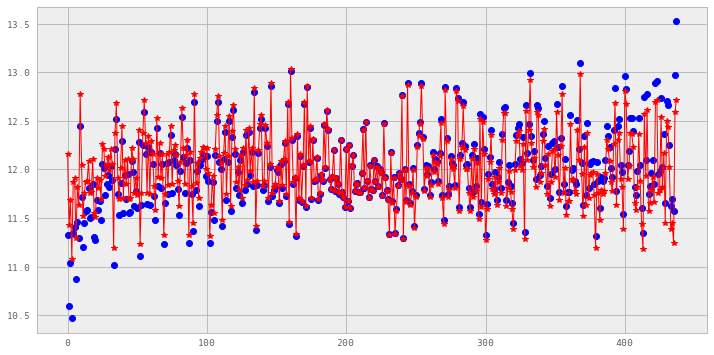

In [136]:
s = np.arange(len(x_test_copy))
plt.figure(figsize=(12,6))
plt.plot(s, x_test_copy['y_actual'], 'o', color='b', label='actual')
plt.plot(s, x_test_copy['y_hat'], '*-', color='r', label='XGB')
plt.show()

In [208]:
i = 0
eli5.show_prediction(xgbr.best_estimator_.get_booster(), x_test_copy.iloc[i, :-3], show_feature_values=True)

In [ ]:
#Light GBM
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric = 'mean_squared_error')
params_grid = {'learning_rate': [0.02, 0.05, 0.1], 'n_estimator': [50, 100, 1000, 5000], 'max_depth': [5,10,20], 'num_leaves': [10, 20, 31, 40]}
lgb = GridSearchCV(lgb, params_grid, n_jobs=-1, verbose=1)
lgb.fit(x_train, y_train)

y_hat_lgb = lgb.predict(x_test)
print lgb
print mean_squared_error(y_hat_lgb, y_test)
mse_dict['LightGBM'] = mean_squared_error(y_hat_lgb, y_test)

# y_pred_lgb = lgb.predict(d_test.drop('Id', axis=1))
# Ames_lgb = pd.DataFrame(data={'Id': d_test['Id'], 'SalePrice': np.exp(y_pred_lgb)})
# Ames_lgb.to_csv('Ames_lgb.csv')

In [ ]:
#Plots of predicted values using base models versus actual
t = np.arange(len(y_test))
results = pd.DataFrame(data={'Actual': y_test, 'Lasso': y_hat_lin, 'KernelRidge': y_hat_krr,'RandomForest': y_hat_rfr, 'GradientBoosting': y_hat_gbr, 'XGBoost': y_hat_xgb, 'LightGBM': y_hat_lgb})
results = results.sort_values(by = 'Actual', axis  = 0)

colors = 'grbkmy'
models = ['Lasso', 'KernelRidge', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']
plt.figure(figsize=(18,12))
for k, m in enumerate(models):
    ax = plt.subplot(len(models)/2, 2, k+1)
    plt.plot(t, results.Actual, label='Actual', color='magenta')
    plt.plot(t, results[m], label=m, color=colors[k])
    plt.xlabel('Home no.')
    plt.ylabel('Price')
    plt.autoscale()
    plt.legend(loc='best')
    plt.grid()
plt.suptitle("Predicted Ames Home versus Actual from Test Data", fontsize=15)
#plt.tight_layout()

results.to_csv('train_test_results.csv')

In [78]:
print mse_dict

{'XGBoost': 0.0198706546650938}


In [ ]:
#residual plots for test results

models = ['Lasso', 'KernelRidge', 'RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM']
results_residual = pd.DataFrame()
for model in models:
    results_residual[model] = results['Actual'] - results[model]
results_residual['Actual'] = results['Actual']

colors = 'grbkmy'
plt.figure(figsize=(18,12))
for i, m in enumerate(models):
    ax = plt.subplot(len(models)/2, 2, i+1)
    plt.plot(results_residual.Actual, results_residual[m], 'o', color=colors[i], label=m)
    plt.xlabel('Actual Price')
    plt.ylabel('Residual')
    plt.xlim([10,14])
    plt.ylim([-1,1])
    plt.legend(loc='upper left')
plt.suptitle("Residual of predicted and actual")

In [ ]:
#Base estimator prediction

models = [lin, krr, gbr, xgb, lgb]
def get_prediction(models, x_test):
    nrow = x_test.shape[0]
    results = np.zeros(nrow, len(models))
    for i in range(len(models)):
        model = models[i]
        results[:, i] = model.predict(x_test)
    return results    
    
pred_results = get_prediction(models, d_test.drop('Id', axis=1))
pred_results.rename(columns={'0': 'Lasso', '1': 'KRR', '2': 'GBR', '3': 'XGB', '4': 'LGB'})

predictions = pd.DataFrame(data={'Id': d_test['Id'], 'Lasso': np.exp(pred_results.iloc[:, 0]),
                                 'KernelRidge': np.exp(pred_results.iloc[:, 1]),'GradientBoosting': np.exp(pred_results.iloc[:, 2]),
                                 'XGBoost': np.exp(pred_results.iloc[:, 3]), 'LightGBM': np.exp(pred_results.iloc[:, 4])})

predictions['Mean'] = np.mean(predictions.drop('Id', axis=1), axis=1)
predictions.to_csv('predictions_base_estimator.csv')

In [ ]:
#Stacking
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb


#1st: Build 5 meta-models (Lasso, KRR, GBR, XGB, LGB) using train-test results, respectively.
#2nd: Predict xs-test (base estimators' prediction data) using 5 meta-models, respectively, and then average the predicted data.

results = pd.read_csv('train_test_results.csv')
predictions = pd.read_csv('predictions.csv')


xs = results[['Lasso', 'KernelRidge', 'GradientBoosting', 'XGBoost', 'LightGBM']]
ys = results['Actual']

xs_test = np.log(predictions.drop(['Id', 'mean'], axis=1))

# #Lasso
lins = Pipeline([('Poly', PolynomialFeatures(degree=2)), ('Linear', LassoCV(alphas=np.logspace(-3,2,5), cv=3, max_iter=1e5, fit_intercept=False))])
lins.fit(xs, ys)
y_hat_lins = lins.predict(xs_test)
# print lins
#KernelRidge
krrs = KernelRidge(kernel='polynomial')
params_krrs = {'alpha': [0.1, 0.2, 0.5], 'degree': [2,3], 'coef0':[0.5,2.5,5]}
krrs = GridSearchCV(krrs, params_krrs, cv=3, n_jobs=-1, verbose=1)
krrs.fit(xs, ys)
y_hat_krrs = krrs.predict(xs_test)
# print krrs
#GradientBoosting
gbrs = GradientBoostingRegressor()
params_gbrs = {'learning_rate': [0.05, 0.1], 'n_estimators': [100, 500], 'max_depth': [3,5],'min_samples_split': [2,3]}
gbrs=GridSearchCV(gbrs, params_gbrs, cv=3, n_jobs=-1, verbose=1)
gbrs.fit(xs, ys)
y_hat_gbrs = gbrs.predict(xs_test)
# print gbrs              
# #XGBoost
xgbs = xgb.XGBRegressor()
params_xgbs = {'max_depth': [3,5,8], 'learning_rate': [0.05, 0.1, 0.2], 'n_estimators': [20, 100, 1000], 'objective': ['reg:linear'], 'gamma': [i/10.0 for i in range(1,3)], 'reg_alpha': [i/10.0 for i in range(0,3)], 'reg_lambda': [0, 0.2, 0.5, 0.8, 1.0]}
xgbs = GridSearchCV(xgbs, params_xgbs, cv=3, n_jobs=-1, verbose=1)
xgbs.fit(xs, ys)
y_hat_xgbs = xgbs.predict(xs_test)
# print xgbs
#LightGBM
lgbs = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric = 'mean_squared_error')
params_lgbs = {'learning_rate': [0.05, 0.1], 'n_estimator': [100, 500], 'max_depth': [3,5]}
lgbs = GridSearchCV(lgbs, params_lgbs, n_jobs=-1, verbose=1)
lgbs.fit(xs, ys)
y_hat_lgbs = lgbs.predict(xs_test)
#print lgbs
predictions_stack = pd.DataFrame(data={'Id': predictions['Id'], 'Lasso': np.exp(y_hat_lins), 'KernelRidge': np.exp(y_hat_krrs),
                                      'GradientBoosting': np.exp(y_hat_gbrs), 'LightGBM': np.exp(y_hat_lgbs)})
predictions_stack['Mean'] = np.mean(predictions_stack.drop('Id', axis=1), axis=1)
predictions_stack.to_csv('predictions_stack.csv')
submission = pd.DataFrame({'Id': predictions_stack['Id'], 'SalePrice': predictions_stack['Mean']})
submission.to_csv('submission.csv',index=False)